# Predictor Explainer

The following Python code runs after the user has selected all the `X`'s, `y`, `Datetime` (optional), `Weights` (optional) and other parameters. [PyJMP](https://github.com/industrial-data/pyJMP) needs to be installed.

The main idea is to find variables (`X`'s or tags) that correlate with at certain target (`y`). Intentionally, the purpose is to generate **descriptive models** to find interesting variables to visualize.

More information can be found here:

* [Predictor Explainer](https://github.com/industrial-data/predictor-explainer/pyJMP)
* [Industrial data science – a review of machine learning applications for chemical and process industries](https://pubs.rsc.org/en/content/articlelanding/2022/re/d1re00541c)


In [1]:
__author__ = 'Francisco Navarro; Juline Gillard'
__license__ = "BSD Clause-3"
__version__ = '2023.09.17'
__maintainer__ = 'Francisco Navarro; Carlos Perez-Galvan'
__status__ = 'beta'
__url__ = 'https://github.com/industrial-data/predictor-explainer'

# Loading Python libraries

In [2]:
import numpy as np
import pandas as pd
import shap
import umap
import hdbscan
from lightgbm.sklearn import LGBMRegressor
import matplotlib.pyplot as plt
import time
import os
import re

# To deactivate plots, change to False
is_plotting = True

if is_plotting:
    import umap.plot

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://n

# Loading data from temp files (saved by JMP)

<div class="alert alert-block alert-warning">New CSV files are generated only when the user clicks OK in the Predictor Explainer add-in.</div>

In [3]:
current_path = os.getcwd()

temp_data_path = os.path.join(current_path, 'temp')

print(temp_data_path)

assert os.path.exists(temp_data_path), "The 'temp' folder does not exist" 

C:\Users\fxn0478\AppData\Roaming\SAS\JMP\Addins\Predictor_Explainer\temp


In [4]:
y_path_csv = os.path.join(temp_data_path,'y.csv')
X_path_csv = os.path.join(temp_data_path,'X.csv')
t_path_csv = os.path.join(temp_data_path,'t.csv')
W_path_csv = os.path.join(temp_data_path,'W.csv')
user_parameters_csv = os.path.join(temp_data_path,'user_parameters.csv')

is_unspervised_learning = False

try:
    y = pd.read_csv(y_path_csv)
except:
    print("target column couldn't be loaded correctly, assuming unspervised learning ")
    is_unspervised_learning = True

try:
    X = pd.read_csv(X_path_csv)
    JMP_row_index = X['row_index'].copy();
    del X['row_index']
    
except Exception:
    print("X columns couldn't be loaded correctly, make sure they exist")    

try:
    t = pd.read_csv(t_path_csv)
except:
    print('Time column was not defined by user')
    
try:
    W = pd.read_csv(W_path_csv)
except:
    print('Weights were not defined by user')

try:
    JMP_user_parameters = pd.read_csv(user_parameters_csv)
except:
    print('User parameters not defined')

Time column was not defined by user
Weights were not defined by user


In [5]:
print('Options defined in JMP addin: \n\n', JMP_user_parameters);

Options defined in JMP addin: 

    nTrees  SignalToNoiseRatio  NdimUMAP     metric  nrows
0     100                   1         2  euclidean      1


In [6]:
# This function will be used at the end to create umap from RF selected features
def umap_princ_components(X, n_umap_components=2, distance='euclidean'):
    '''Takes not scaled X(obs,variables) and reduces to n_comp dimensions
    by using umap reducer embedding.
    
    It returns a dataframe with the following columns:
        n_comp (embeddings)
        euclidan distance between consecutive rows
        sum(n_comp)
        labels for clusters
        outlier score based on density'''
    
    #n_umap_components = 2 # default and paper
    
    print('N of umap dimensions', n_umap_components)
    print('Distance metric:', distance)
    
    # Data prep
    
    # Umap does not handle NaNs (TODO improve)
    # Simplest time series approach:
    # forward filled and then back filled
    # (!) Not compatible with batch data
    X_unsupervised = X.copy()
    
    X_unsupervised = X_unsupervised.fillna(method='ffill')
    X_unsupervised = X_unsupervised.fillna(method='bfill')
    
    # Drops any reamining column with of empty values
    X_unsupervised = X_unsupervised.dropna(axis=1, how='all')
    
    # Robust normalization
    X_unsupervised_normalized = ((X_unsupervised-X_unsupervised.quantile(0.03)) /
                                 (X_unsupervised.quantile(0.97)-X_unsupervised.quantile(0.03)))
    
    # If values are fairly constant, (q97-q03) division returns NaN (TODO improve)
    X_unsupervised_normalized = X_unsupervised_normalized.dropna(axis=1, how='any')

    X_unsupervised_normalized = X_unsupervised_normalized.clip(0, 1)
    
    # Dimensionality reduction
    
    # Choice of parameters is indicated but also shared with
    # paper https://doi.org/10.1016/j.conengprac.2019.104189
    
    # TODO Exploit AlignedUMAP for time varying data
    # https://umap-learn.readthedocs.io/en/latest/aligned_umap_politics_demo.html
    
    if distance == 'euclidean':
        y_distance = 'l2'
    
    if distance == 'manhattan':
        y_distance = 'l1'
        
    if is_unspervised_learning:
    
        embedding = umap.UMAP(n_neighbors=15, # default and paper
                            min_dist=0.1, # default and paper
                            n_components=n_umap_components,
                            metric=distance,
                            output_metric=distance,
                            target_metric=y_distance,
                            #random_state=42, # uncomment to get slower but reproducible results
                            ).fit(X_unsupervised_normalized)
    else:
        embedding = umap.UMAP(n_neighbors=15, # default and paper
                            min_dist=0.1, # default and paper
                            n_components=n_umap_components,
                            metric=distance,
                            output_metric=distance,
                            target_metric=y_distance,
                            #random_state=42, # uncomment to get slower but reproducible results
                            ).fit(X_unsupervised_normalized, y=y) #add 'y' as function input
        
        
        
    # Generating umap column names
    umap_col_names = ['umap'+str(i+1) for i in range(n_umap_components)]
    
    # Saving table
    array_umap_components = embedding.embedding_
    df_umap = pd.DataFrame(array_umap_components, columns=umap_col_names)
    

    
    # Clustering and density analysis 

    n_observations = len(X_unsupervised_normalized.index)
    percentual_threshold = 0.05 # % of data required to form cluster 

    # array_umap_components = df_umap.iloc[:,:n_umap_components].values

    clusterer = hdbscan.HDBSCAN(
                        min_samples=5,
                        min_cluster_size=round(percentual_threshold*n_observations),
                        ).fit(array_umap_components)

    labels = clusterer.labels_  

    are_clustered = (labels >= 0) #-1 are unclustered points
    
    df_umap['umap_clusters'] = labels
    df_umap['outlier_score'] = clusterer.outlier_scores_
    
    # Row or time difference
    diff_period = int(JMP_user_parameters['nrows'])
    print('N of rows for finite differences', diff_period)
    
    df_umap_shift = df_umap.shift(periods = diff_period, axis = 0).copy()
    
    if distance == 'euclidean':
        # 2-norm distance between consecutive points
        df_umap['distance_diff_umap'] = np.linalg.norm(df_umap.values - df_umap_shift.values, axis=1)
    
    if distance == 'manhattan':
        # 1-norm distance between consecutive points
        df_umap['distance_diff_umap'] = np.linalg.norm(df_umap.values - df_umap_shift.values, ord=1, axis=1)
    
    
    # IMPORTANT TODO we are adding all umap components as target function
    # this assumes that dimensions have no importance (?) (unlike PCA)
    df_umap['sum_umap_comp'] = df_umap.iloc[:,:n_umap_components].sum(axis=1)
    
    if not(is_unspervised_learning):
        df_umap['y'] = y
        
    df_umap_path_csv = os.path.join(temp_data_path,'df_umap.csv')
    
    df_umap.index = JMP_row_index
    df_umap.to_csv(df_umap_path_csv)
    df_umap = df_umap.reset_index()

    if is_plotting:
        
        if n_umap_components == 1:
            cmap = plt.cm.Paired
            df_umap.reset_index().plot.scatter(x='index', y='umap1', c=cmap(labels), xlabel='row index', ylabel='umap 1D')
        
        if n_umap_components == 2:
            umap.plot.connectivity(embedding, show_points=True, labels=labels)
        #df_umap.plot()
        
        if n_umap_components >= 3:
            
            #cmap = plt.cm.Paired
            
            df_umap_parallel = df_umap[umap_col_names+['umap_clusters']]
            df_umap_parallel = df_umap_parallel[are_clustered]
            
            n_clusters = len(df_umap_parallel['umap_clusters'].unique())
            
            pd.plotting.parallel_coordinates(df_umap_parallel,
                                             'umap_clusters')
    
    return df_umap, n_umap_components



# Unsupervised step (only if target was not given by user)

In [7]:
if is_unspervised_learning:
    print('Reducing dimensionality and using such as target')
    
    n_umap_components = int(JMP_user_parameters['NdimUMAP'])
    distance = str(JMP_user_parameters['metric'][0])
    
    df_umap, n_umap_components = umap_princ_components(X, n_umap_components, distance)
    y = df_umap['sum_umap_comp'].copy().to_frame()

# Data preparation

In [8]:
# JMP loads everything as data frames

def rename_df_columns(my_dataframe):
    '''Light GBM does not support special JSON Characters in column names yet
    This function susbtitues by _ all characters in column names that are not letters or numbers'''
    
    print(type(my_dataframe))
    
    # If errors, uncomment the following line.
    my_dataframe = my_dataframe.rename(columns = lambda str_column:re.sub(r'[^A-Za-z0-9_]+','_', str_column))
        
    # Once fixed, the following reg. exp. will keep special JSON charaters
    # my_data_frame = my_data_frame.rename(columns = lambda str_column:re.sub(r'[^\x00-\x7F]+','', str_column))
    
    return my_dataframe


y = rename_df_columns(y) # removing special characters
y = y.iloc[:, 0] # converting df to series


tic = time.time()

# Removes X columns that are non numeric (e.g. dates in X)
X = X.select_dtypes(include=np.number)


# Adding index in case a counter fits the data well (acumulation)
# X['SHAP_row_index'] = range(1, len(X) + 1)
X = rename_df_columns(X) # removing special characters

if y.name in X.columns:
    print('Output columns was given as input! Removing it from X')
    del X[y.name]
    
try:
    t;
except NameError:
    t_exists = False
else:
    t_exists = True
    t = rename_df_columns(t) # removing special characters
    
    #t.to_csv('C:\Temp\JMP_time.csv')
    
    t.iloc[:,0] = pd.to_datetime(t.iloc[:,0], unit='s', origin=pd.Timestamp('1904-01-01'))
    t = t.iloc[:, 0] # converting to series
    
try:
    W;
except NameError:
    W_exists = False
else:
    W_exists = True
    W = rename_df_columns(W) # removing special characters
    
    #W.to_csv('C:\Temp\JMP_weight.csv')
    
    W = W.iloc[:, 0] # converting to series


    
# print('X head: \n', X.head())
# print('X tail: \n', X.tail())
# print('y: \n', y)

assert (len(X) == len(y) ), 'Number of rows of X, y does not match!'

#check if NaN exist in Y, W, t and remove corresponding X 
y.dropna(inplace=True)
index_not_nan = y.index
X = X.loc[index_not_nan,:]

try:
    X = X.drop('N_Rows', axis=1)
except:
    print("N_Rows column was not in X")

JMP_row_index = JMP_row_index[index_not_nan]

if t_exists:
    t = t[index_not_nan]
    t.dropna(inplace=True)
    t_index_not_nan = t.index
    
    y = y[t_index_not_nan]
    X = X.loc[t_index_not_nan,:]
    assert (len(X) == len(y) == len(t)), 'Number of rows of X, y and t does not match'

if W_exists:
    W = W[index_not_nan] 
    W.fillna(0)
    W = (W-W.min())/(W.max()-W.min())
    assert (len(X) == len(y) == len(W)), 'Number of rows of X, y and W does not match'
    weights = W
    
# print('X head (after dropping NaN): \n', X.head())
# print('X tail (after dropping NaN): \n', X.tail())
# print('y (after dropping NaN): \n', y)    

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
N_Rows column was not in X


In [9]:
y.to_frame().head(10) # head (after dropping NaNs)

,yield
0,69.400623
1,66.532666
2,71.102193
3,69.793481
4,71.489516
5,69.055089
6,69.161052
7,71.399191
8,70.125880
9,69.726319


In [10]:
X.head(10) # X head (after dropping rows from y NaNs)

,Temp1,FlowC1,TempC9,TempC3,PressureC1,Temp4,Temp11,OC1,FlowC3,Random_Normal
0,139.9857,432.0636,86.6133,180.5578,215.0627,187.4331,30.8983,3.1033,8.6279,-1.336678
1,131.0470,487.4029,97.6100,172.6575,205.0999,179.5089,31.9099,4.7408,8.7662,1.086396
2,118.2666,437.3516,88.4967,165.9400,205.0304,172.9262,29.9165,4.2925,8.5319,-0.960064
3,118.1769,481.8314,95.3483,167.2085,205.2561,174.2338,30.6229,4.4558,8.6260,-0.793011
4,120.7891,412.6471,82.9533,167.0326,205.0883,173.9681,29.4977,3.4600,8.5939,-0.263874
5,121.7929,470.8127,93.5633,169.7501,203.8242,176.3803,29.8406,4.5900,8.4507,-1.184972
6,120.8903,493.8452,99.8533,169.9978,204.1858,176.8023,35.5254,4.1296,8.4093,-1.407459
7,119.4786,429.0580,85.8233,166.9747,204.3738,173.6503,31.1274,3.7133,8.4414,0.067741
8,124.8390,414.0616,82.6411,171.4144,204.1163,178.0371,31.7608,3.0900,8.3289,-1.544540
9,121.6020,505.6681,99.9829,169.5163,204.1510,176.3334,32.3697,4.6217,8.5193,-0.155491


In [11]:
print(X.columns)

Index(['Temp1', 'FlowC1', 'TempC9', 'TempC3', 'PressureC1', 'Temp4', 'Temp11',
       'OC1', 'FlowC3', 'Random_Normal'],
      dtype='object')


import dtale
d = dtale.show(X)


# Feature generation

In [12]:
diff_period = int(JMP_user_parameters['nrows'])

print('N of rows for finite difference feature', diff_period)

X_diff = X.diff(periods = diff_period, axis = 0).copy()
X_diff.columns = ['Diff_'+col for col in X_diff.columns]

print('Finding and dropping duplicated columns generated automatically')
dup_columns = set(X.columns) & set(X_diff.columns)
X_diff.drop(list(dup_columns), axis=1, inplace=True)

X = pd.concat([X, X_diff], axis=1)

toc = time.time() - tic
print('Loading data time [s]:', round(toc, 2))
tic = time.time()

N of rows for finite difference feature 1
Finding and dropping duplicated columns generated automatically
Loading data time [s]: 0.11


Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead


In [13]:
#add some time features

print('Starting date feature generation')

if t_exists and (t.name in X.columns): 
    # User needs to introduce date as X and t 
    print(t.head())
    
    # Check first five years in time column
    # if index was used as time year will be around 1904 (starting date in JMP)
    
    is_date_correct = (1960 <= np.nanmean(t.dt.year[0:5]))
                       
    if is_date_correct:
        print('Creating time features')
    
        #t = t[diff_period:len(t)] # TODO WHY?
    
        day_of_month = True
        day_of_week = True
        day_of_year = True
        week = True
        week_of_month = True
        month = True
        quarter = True
        semester = True
        year = True
        hour = True
        minute = True

        if day_of_month:
            X['day_of_month'] = t.dt.day
        if day_of_week:
            X['day_of_week'] = t.dt.dayofweek
        if day_of_year:
            X['day_of_year'] = t.dt.dayofyear
        if week:
            X['week_of_year'] = t.dt.isocalendar().week
        if week_of_month:
            X['week_of_month'] = t.dt.day.divide(7).apply(np.floor)
        if month:
            X['month'] = t.dt.month
        if quarter:
            X['quarter'] = t.dt.quarter
        if semester:
            X['semester'] = t.dt.month.divide(6).apply(np.ceil) # NEW
        if year:
            X['year'] = t.dt.year
        if hour:
            X['hour'] = t.dt.hour
        if minute:
            X['minute'] = t.dt.minute

toc = time.time() - tic
print('Date parsing finished, total time [s]:', round(toc, 2))
tic = time.time()

Starting date feature generation
Date parsing finished, total time [s]: 0.01


# Modeling (RF LightGBM)

In [14]:
n_trees = int(JMP_user_parameters['nTrees']) # number of trees in the forest

signal_to_noise = float(JMP_user_parameters['SignalToNoiseRatio']) # ratio to remove non features near the noise

#add noise
normalNoise = np.random.normal(size = len(X))
uniNoise = np.random.uniform(size = len(X))

#yy = y.values().copy()
yy = y.to_numpy().copy()
np.random.shuffle(yy)

X['Normal Noise'] = normalNoise
X['Uniform Noise'] = uniNoise
X['Shuffle Yield Noise'] = yy

lgbm = LGBMRegressor(n_estimators = n_trees) #keeping default for the other parameters
if W_exists:
    #weights = np.array(weights).reshape(1,-1).flatten()
    #weights = weights[index_not_nan]  #not needed since lgbm handles missing values
    y_model = lgbm.fit(X,y,sample_weight = np.array(weights).flatten())
else:
    y_model = lgbm.fit(X,y)  #LightGBM (as XGBoost) do not support some character in strings, this is why put X into an array

imp_lgbm = lgbm.feature_importances_
sorted_indices_lgbm = np.argsort(imp_lgbm)[::-1]


toc = time.time() - tic
print('Modeling time [s]:', round(toc, 1))
tic = time.time()


# TODO can we drop columns now so the Tree explainer goes faster?
# If not, we need to rerun this for the explainer

Modeling time [s]: 0.0


Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead


# Model (over)fit

<div class="alert alert-block alert-info">
    <b>This is a DESCRIPTIVE model intended to find correlations and anomalies in the data to be analyzed.</b> 
    This means overfitting is expected and the model cannot be used to predict a different data set (as the process may have changed). <b>To expand the scope of this, there should be a proper train/test split in the cell above</b>.
    Alternatively, user can train/test by setting several rows with 0 weights to see if performs equaly well.
</div>

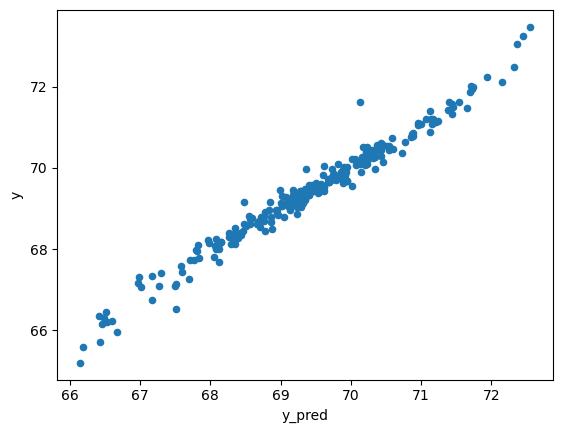

In [15]:
if W_exists:
    y_predictions = y_model.predict(X)
    df_Ys = pd.DataFrame({'y': y, 'y_pred': y_predictions, 'Weight': W})
    df_Ys.plot.scatter(x='y_pred', y='y', c='Weight', colormap='viridis')

else:
    y_predictions = y_model.predict(X)
    df_Ys = pd.DataFrame({'y': y, 'y_pred': y_predictions})
    df_Ys.plot.scatter(x='y_pred', y='y')

# Explainer (shap)

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


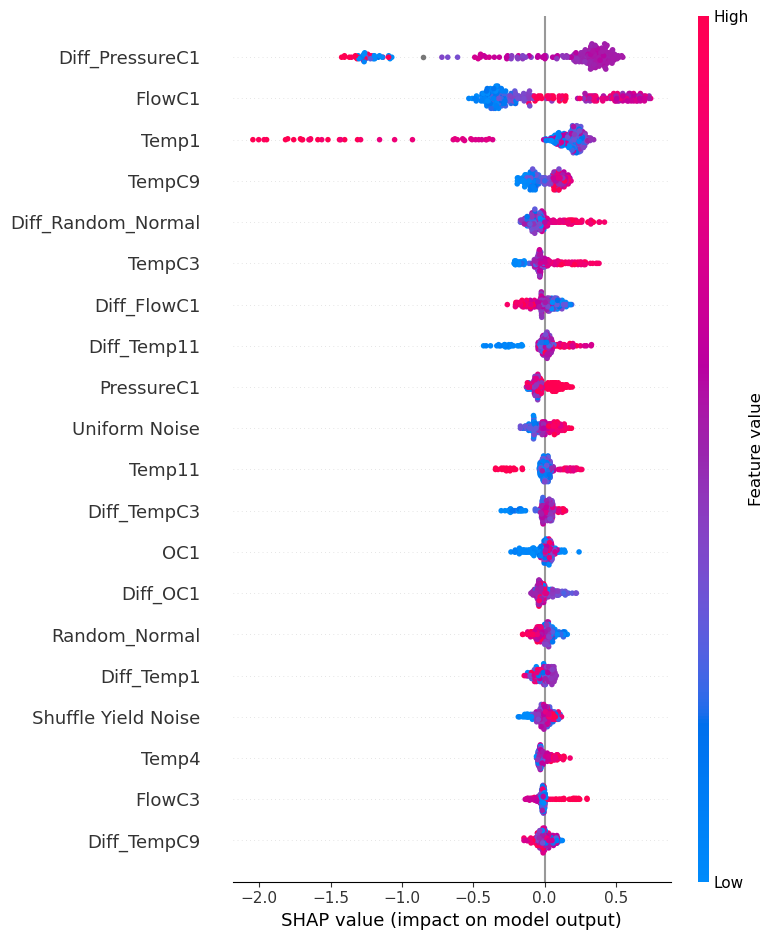

In [16]:
explainer_lgbm = shap.TreeExplainer(lgbm, feature_perturbation='tree_path_dependent') #by default if do not provide any backgound dataset: tree_path_dependent
shap_values_lgbm = explainer_lgbm.shap_values(X)

if is_plotting:
    shap.summary_plot(shap_values_lgbm, X)

In [17]:

df_shap_values = pd.DataFrame(shap_values_lgbm, index=X.index, columns=X.columns)

shap_lgbm_abs = abs(shap_values_lgbm)

mean_shap = shap_lgbm_abs.mean(axis=0)
std_shap = shap_lgbm_abs.std(axis=0)

#for some features,shap values always equal to 0 --> mean_shap contains null values
#for the ones that are null put an extremely small values?
mean_shap[np.where(mean_shap==0)] = 1e-9
CoefVariance_shap = std_shap/mean_shap 

#table of the mean and std shap
df_global_shap_values = pd.DataFrame({'Tags':X.columns,
                     'mean':mean_shap,
                     'std':std_shap,
                     'CoefVariance':CoefVariance_shap})

df_global_shap_values.sort_values(by='mean', ascending=False, inplace=True)

col_list_by_mean_shap = df_global_shap_values['Tags'].tolist()

# Reodering cloumns by shap mean value
X = X[col_list_by_mean_shap]
df_shap_values = df_shap_values[col_list_by_mean_shap]

list_ordered_factors = col_list_by_mean_shap
index_noise_shuffle = list_ordered_factors.index('Shuffle Yield Noise')
index_noise_normal = list_ordered_factors.index('Normal Noise')
index_noise_uni = list_ordered_factors.index('Uniform Noise')
min_index_noise = min(index_noise_shuffle,index_noise_normal,index_noise_uni)

col_name_noise = col_list_by_mean_shap[min_index_noise]
# Drop columns which SHAP average is below noise to ratio cut

# Gets the noise mean value
#noise_impact = float(df_global_shap_values['mean'].tail(1))
noise_impact = df_global_shap_values.set_index('Tags')['mean'][col_name_noise]
noise_cut_impact = signal_to_noise * noise_impact

# Finds columns with higher impact
bool_columns_after_noise_ratio_cut = df_global_shap_values['mean'].gt(noise_cut_impact)
col_list_after_noise_ratio_cut = df_global_shap_values[bool_columns_after_noise_ratio_cut]['Tags'].tolist()
print('list of columns above noise ratio: ', col_list_after_noise_ratio_cut)


# Appends noise column to visualize baseline
col_list_after_noise_ratio_cut.append(col_name_noise)

if 'SHAP_row_index' in col_list_after_noise_ratio_cut:
    # if a counter is important, this should be found by time index
    col_list_after_noise_ratio_cut.remove('SHAP_row_index')

# Alternative list with columns which SHAP average is just below noise (no noise ratio)
col_list_by_mean_shap_cut = col_list_by_mean_shap[0:(min_index_noise+1)]

# Simple index
# X['SHAP_row_index'] = range(1, len(X) + 1)

try:
    # Match JMP row index in case there were excluded rows
    X['SHAP_row_index'] = JMP_row_index
except:
    # Failed using JMP row indexes
    print('JMP row index was not passed properly to the solution.')
    X['SHAP_row_index'] = range(1, len(X) + 1)

X_SHAP_row_index = X['SHAP_row_index'].copy() # copy index before deleting
X.drop(['SHAP_row_index'], axis=1, inplace=True)


# TODO, which one is better?
# X = X[col_list_by_mean_shap_cut]
X = X[col_list_after_noise_ratio_cut]

#X_normalized = (X-X.min())/(X.max()-X.min()) # not robust to outliers
X_normalized = (X-X.quantile(0.03))/(X.quantile(0.97)-X.quantile(0.03))
X_normalized = X_normalized.clip(0, 1)

# add SHAP row index again
#X_normalized['SHAP_row_index'] = X_SHAP_row_index

if 'SHAP_row_index' in df_shap_values.columns:
    df_shap_values.drop(['SHAP_row_index'], axis=1, inplace=True)
# df_shap_values = df_shap_values[col_list_by_mean_shap_cut]
df_shap_values = df_shap_values[col_list_after_noise_ratio_cut]

# Full list until noise (no signal ratio used in case user wants to reduce it)
df_global_shap_values = df_global_shap_values.iloc[0:(min_index_noise+1),:]

toc = time.time() - tic
print('SHAP time [s]:', round(toc, 1))
tic = time.time()



list of columns above noise ratio:  ['Diff_PressureC1', 'FlowC1', 'Temp1', 'TempC9', 'Diff_Random_Normal', 'TempC3', 'Diff_FlowC1', 'Diff_Temp11', 'PressureC1']
SHAP time [s]: 0.5


In [18]:
# Tables for shap plots in JMP

if t_exists:
    df_shap_values = pd.concat([t, y, df_shap_values], axis=1)
    
    # Adds original row index as unique identifier
    # TODO use JMP index instead (in case there were excluded rows)
    df_shap_values.insert(0, X_SHAP_row_index.name, X_SHAP_row_index.values)
    
    df_shap_values_melted = df_shap_values.melt(id_vars=[X_SHAP_row_index.name, t.name, y.name])
    df_shap_values_melted.columns = [X_SHAP_row_index.name, t.name, y.name, 'tag', 'shap(value)'] 
    
    X_melted = X.melt()
    X_melted.columns = ['tag', 'value']
    
    X_norm_melted = X_normalized.melt()
    X_norm_melted.columns = ['tag', 'norm(value)']
    
    df_shap_plot_table = pd.concat([df_shap_values_melted,
                                    X_melted['value'],
                                    X_norm_melted['norm(value)']],
                                   axis=1)
    
else:
    df_shap_values = pd.concat([y, df_shap_values], axis=1)
    
    # Adds original row index as unique identifier
    df_shap_values.insert(0, X_SHAP_row_index.name, X_SHAP_row_index.values)
    
    df_shap_values_melted = df_shap_values.melt(id_vars=[X_SHAP_row_index.name, y.name])
    df_shap_values_melted.columns = [X_SHAP_row_index.name, y.name, 'tag', 'shap(value)'] 
                                    
    X_melted = X.melt()
    X_melted.columns = ['tag', 'value']
    
    X_norm_melted = X_normalized.melt()
    X_norm_melted.columns = ['tag', 'norm(value)']
    
    df_shap_plot_table = pd.concat([df_shap_values_melted,
                                    X_melted['value'],
                                    X_norm_melted['norm(value)']],
                                   axis=1)



In [19]:
# Exporting files to temp CSVs

In [20]:
df_shap_values_path_csv = os.path.join(temp_data_path,'df_shap_values.csv')
df_global_shap_values_path_csv = os.path.join(temp_data_path,'df_global_shap_values.csv')
df_shap_plot_table_path_csv = os.path.join(temp_data_path,'df_shap_plot_table.csv')

df_shap_values.to_csv(df_shap_values_path_csv)
df_global_shap_values.to_csv(df_global_shap_values_path_csv)
df_shap_plot_table.to_csv(df_shap_plot_table_path_csv)


toc = time.time() - tic
print('Exporting time [s]:', round(toc, 2))
tic = time.time()


Exporting time [s]: 0.08


In [21]:
# Visualization of tables in Notebook

In [22]:
df_shap_values

,SHAP_row_index,yield,Diff_PressureC1,FlowC1,Temp1,TempC9,Diff_Random_Normal,TempC3,Diff_FlowC1,Diff_Temp11,PressureC1,Uniform Noise
0,1,69.400623,-0.849063,0.124361,0.183500,0.108179,-0.017927,0.011662,0.083371,0.036028,-0.067392,0.073067
1,2,66.532666,-1.260941,-0.027233,0.161145,0.081894,0.144625,-0.052820,-0.175340,-0.045609,-0.049014,-0.084360
2,3,71.102193,0.388195,0.102305,0.171797,0.137731,-0.103234,-0.044327,0.117251,0.065904,-0.041393,0.082902
3,4,69.793481,0.319505,-0.066982,0.171152,0.098991,-0.082280,-0.044953,-0.204771,0.050684,-0.111658,0.090344
4,5,71.489516,0.315179,0.510616,0.197918,0.136678,-0.006528,-0.028914,0.151190,0.040943,-0.072464,-0.069816
...,...,...,...,...,...,...,...,...,...,...,...,...
248,249,69.037071,0.266262,-0.418961,0.236081,-0.155770,0.021262,-0.027285,-0.012626,0.005016,-0.063172,-0.018606
249,250,69.202425,-0.014716,-0.350437,0.244592,-0.066077,-0.036049,0.002077,-0.015837,0.016323,-0.042156,0.014350
250,251,69.409546,0.348221,-0.320129,0.249377,-0.089483,-0.049556,-0.035771,0.015164,-0.003464,-0.067293,0.079959
251,252,69.072711,0.313435,-0.393129,0.195970,-0.184330,0.185113,-0.031165,-0.024922,-0.004183,-0.063027,-0.076970


In [23]:
y.name

'yield'

In [24]:
# df_shap_values.describe()

In [25]:
df_global_shap_values

,Tags,mean,std,CoefVariance
14,Diff_PressureC1,0.478718,0.353921,0.739311
1,FlowC1,0.346142,0.173454,0.501106
0,Temp1,0.339536,0.425559,1.253353
2,TempC9,0.093625,0.044452,0.474785
19,Diff_Random_Normal,0.090373,0.078425,0.867792
3,TempC3,0.088155,0.084492,0.958442
11,Diff_FlowC1,0.073048,0.053822,0.736808
16,Diff_Temp11,0.070209,0.092134,1.312282
4,PressureC1,0.066088,0.035615,0.538904
21,Uniform Noise,0.064612,0.041057,0.635450


In [26]:
#df_global_shap_values.describe()

In [27]:
df_shap_plot_table

,SHAP_row_index,yield,tag,shap(value),value,norm(value)
0,1,69.400623,Diff_PressureC1,-0.849063,NaN,NaN
1,2,66.532666,Diff_PressureC1,-1.260941,-9.962800,0.003997
2,3,71.102193,Diff_PressureC1,0.388195,-0.069500,0.488637
3,4,69.793481,Diff_PressureC1,0.319505,0.225700,0.503097
4,5,71.489516,Diff_PressureC1,0.315179,-0.167800,0.483821
...,...,...,...,...,...,...
2525,249,69.037071,Uniform Noise,-0.018606,0.477604,0.472023
2526,250,69.202425,Uniform Noise,0.014350,0.671618,0.683087
2527,251,69.409546,Uniform Noise,0.079959,0.868948,0.897761
2528,252,69.072711,Uniform Noise,-0.076970,0.239808,0.213327


In [28]:
#df_shap_plot_table.describe()

# UMAP Dimensionality reduction for selected inputs

In [29]:
# X has already the RF selected features ordered by importance
X.head()

,Diff_PressureC1,FlowC1,Temp1,TempC9,Diff_Random_Normal,TempC3,Diff_FlowC1,Diff_Temp11,PressureC1,Uniform Noise
0,NaN,432.0636,139.9857,86.6133,NaN,180.5578,NaN,NaN,215.0627,0.892068
1,-9.9628,487.4029,131.0470,97.6100,2.423074,172.6575,55.3393,1.0116,205.0999,0.168995
2,-0.0695,437.3516,118.2666,88.4967,-2.046460,165.9400,-50.0513,-1.9934,205.0304,0.740350
3,0.2257,481.8314,118.1769,95.3483,0.167053,167.2085,44.4798,0.7064,205.2561,0.907303
4,-0.1678,412.6471,120.7891,82.9533,0.529137,167.0326,-69.1843,-1.1252,205.0883,0.248980


Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead


N of umap dimensions 2
Distance metric: euclidean


Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead


N of rows for finite differences 1


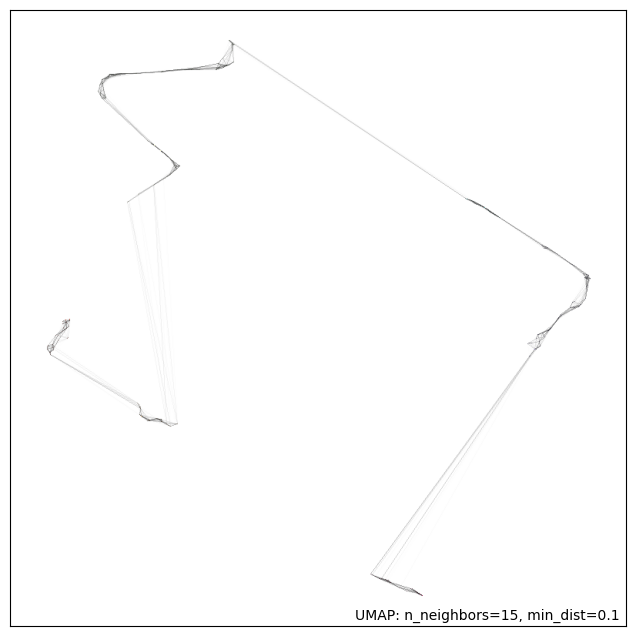

In [30]:
# Function was defined above

if not(is_unspervised_learning):
    n_umap_components = int(JMP_user_parameters['NdimUMAP'])
    distance = str(JMP_user_parameters['metric'][0])
    
    df_umap, n_umap_components = umap_princ_components(X, n_umap_components, distance)

In [31]:
# DO NOT EDIT THIS CELL

# This file is generated only if all the notebook was executed correctly
# JMP will stop if doesn't find it
python_execution_check_csv = os.path.join(temp_data_path,'python_execution.csv')

try:
    os.remove(python_execution_check_csv)
except:
    print('Generating file to confirm python execution')

pd.DataFrame({'Python': [1]}).to_csv(python_execution_check_csv)

Generating file to confirm python execution


#  END